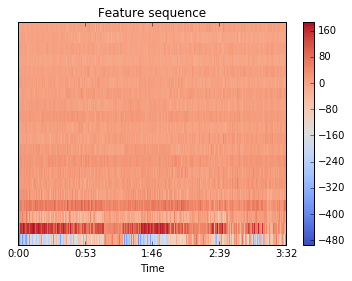

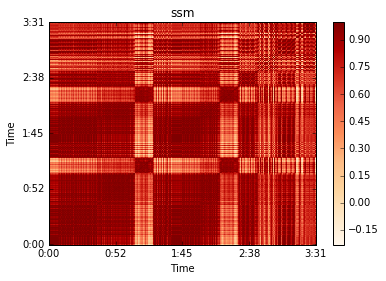

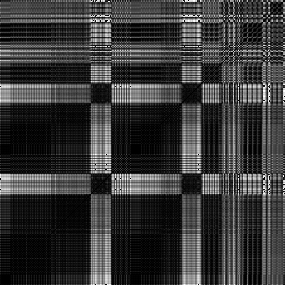

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa

def display_image(ima, width=None, height=None):
    from io import BytesIO
    import PIL.Image
    from IPython.display import display, Image

    im = PIL.Image.fromarray(np.uint8(ima))
    bio = BytesIO()
    im.save(bio, format='png')

    if width is None and height is None:
        display(Image(bio.getvalue(),  format='png'))
    elif width is None:
        display(Image(bio.getvalue(), height=height,  format='png'))
    elif height is None:
        display(Image(bio.getvalue(), width=width,  format='png'))
    else:
        display(Image(bio.getvalue(), width=width, height=height,  format='png'))

        
y, sr = librosa.load('hardest.mp3')

# Uncomment for Chromagram
#feature = librosa.feature.chroma_cqt(y=y, sr=sr)

# Uncomment for MFCC
feature = librosa.feature.mfcc(y=y, sr=sr)

#Uncomment for Tempogram
#oenv = librosa.onset.onset_strength(y=y, sr=sr)
#feature = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)

librosa.display.specshow(feature, sr=sr, x_axis='time')
plt.title('Feature sequence')
plt.colorbar()
plt.show()

downsampling_rate=32
N = feature.shape[1]/downsampling_rate
F = feature.shape[0]
ds = np.ndarray((F,N))
for i in np.arange(N):
    ds[:,i] = np.mean(feature[:,downsampling_rate*i:downsampling_rate*(i+1)],axis=1)

out = np.ndarray((N,N))
for i in np.arange(N):
    a = ds[:,i]
    for j in np.arange(N):
        b = ds[:,j]
        out[i,j] = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

librosa.display.specshow(out, x_axis='time', y_axis='time', sr=sr/downsampling_rate)
plt.title('ssm')
plt.colorbar()
plt.show()
display_image(np.rot90(((1-out)*255)), width=256,height=256)

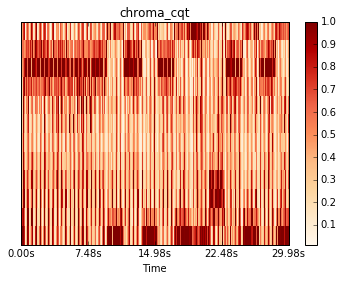

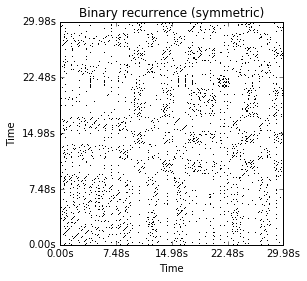

In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa

y, sr = librosa.load('hardest.mp3', duration=30)
chroma_cq = librosa.feature.mfcc(y=y, sr=sr)#, hop_length=512*16)
librosa.display.specshow(chroma_cq, sr=sr, x_axis='time')
plt.title('chroma_cqt')
plt.colorbar()
plt.show()

R = librosa.segment.recurrence_matrix(chroma_cq, metric='cosine')

plt.figure(figsize=(8, 4))
librosa.display.specshow(R, x_axis='time', y_axis='time',
                          aspect='equal')
plt.title('Binary recurrence (symmetric)')
plt.show()